# Exp1: Regression Task Design Based On Feedforward Neural Network

## 1、Import Packages

In [1]:
import random
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader, sampler, Dataset, TensorDataset
from datetime import datetime
import torch.optim as optim 
import torch
from torchsummary import summary
import matplotlib.pyplot as plt

d:\app\Anaconda3\envs\cv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1、Randomly Generate the Dataset
In the 2-D plane of [-10, 10] × [-10, 10], 5000 data points $(x_1, x_2)$ are uniformly randomly generated. Let $y = f(x_1, x_2) = {x_1}^2 + {x_1}{x_2} + {x_2}^2$.

In [2]:
np.random.seed(0)
x = np.random.uniform(-10, 10, (5000, 2))
x1 = x[:, 0]
x2 = x[:, 1]
y = x1**2 + x1*x2 + x2**2
print("the shape of x: ", x.shape)
print("the shape of y: ", y.shape)

the shape of x:  (5000, 2)
the shape of y:  (5000,)


Randomly select 90% of the randomly generated data points for training and the remaining 10% are used for testing.

In [3]:
# get random index of x_train and x_test
np.random.seed(1)
index = np.random.choice(np.arange(0,5000), size=5000, replace=False)
index_train = index[:int(0.9*5000)]
index_val = index[int(0.9*5000):]

# split the dataset into training dataset and test dataset
x_train = x[index_train, :]
y_train = y[index_train]
x_val = x[index_val, :]
y_val = y[index_val]
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("x_val:", x_val.shape)
print("y_val:", y_val.shape)

x_train: (4500, 2)
y_train: (4500,)
x_val: (500, 2)
y_val: (500,)


Customize the dataset using PyTorch API.

In [4]:
# class MyDataset(Dataset):
#     def __init__(self, x, y):
#         self.x = torch.from_numpy(x)
#         self.y = torch.from_numpy(y)
#         self.length = self.x.shape[0]
    
#     def __len__(self):
#         return self.length
    
#     def __getitem__(self, index):
#         return x[index], y[index]

In [5]:
# dst_train = MyDataset(x_train, y_train)
# dst_val = MyDataset(x_val, y_val)

In [6]:
dst_train = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
dst_val = TensorDataset(torch.from_numpy(x_val), torch.from_numpy(y_val))

Load the customized dataset.

In [7]:
bs = 16 # batch size
loader_train = DataLoader(dst_train, batch_size=bs, shuffle=True)
loader_val = DataLoader(dst_val, batch_size=bs, shuffle=True)

## 2、Define train function

In [8]:
def train(model,
          criterion,
          optimizer,
          lr_scheduler,
          loader_train,
          loader_val,
          epochs=1,
          verbose=True,
          print_every=30):
    """Train a model.

    Args:
        model (Module): A PyTorch Module giving the model to train.
        criterion (Loss): The loss function.
        optimizer (Optimizer): An Optimizer object we will use to train the model.
        lr_scheduler (lr_scheduler): 
        loader_train (Dataloader): A Dataloader loading the training dataset.
        loader_val (Dataloader): A Dataloader loading the validation dataset.
        epochs (int, optional): A Python integer giving the number of epochs to train for. Defaults to 1.
        verbose (bool, optional): if set to false then no output will be printed during training. Defaults to True.
        print_every (int, optional): training losses will be printed every print_every iterations. Defaults to 100.

    Returns:
        Tuple: (loss_history, train_acc_history, val_acc_history)
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_loss_history, val_loss_history = [], []
    model = model.to(device=device)
    # l = len(loader_train)
    dtype = torch.float32
    
    start_time = datetime.now()
    for e in range(epochs):
        train_loss = 0
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=dtype)
    
            preds = model(x).squeeze()
            loss = criterion(preds, y)

            # Zero out all of the gradients for the variables which the optimizer will update.
            optimizer.zero_grad()

            loss.backward()  # backwards pass
            optimizer.step()  # update the parameters of the model
            train_loss += loss.item()

        train_loss /= len(loader_train)
        train_loss_history.append(train_loss)
        lr_scheduler.step(train_loss)  # update the learning rate
        
        # validate the updated model
        val_loss = 0
        model.eval()
        for t, (x, y) in enumerate(loader_val):
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=dtype)
            preds = model(x).squeeze()
            loss = criterion(preds, y)
            val_loss += loss.item()
        val_loss /= len(loader_val)
        val_loss_history.append(val_loss)
        
        if verbose:
            print("(Epoch %d / %d) train_loss = %.4f, val_loss = %.4f" % 
                  (e+1, epochs, train_loss, val_loss))
            
    # print the training time
    end_time = datetime.now()
    h, remainder = divmod((end_time - start_time).seconds, 3600)
    m, s = divmod(remainder, 60)
    time_str = "Time %d:%d:%d" % (h, m, s)
    print()
    print("training time:", time_str)
    
    return train_loss_history, val_loss_history


## 3、Define the loss function, model and optimizer
First, define the fully connected neural network architecture.

In [15]:
class fcn(nn.Module):
    def __init__(self, hidden_layers, activation_function):
        depth = len(hidden_layers)
        assert depth>=1  # at least one hidden layer
        
        super().__init__()
        hidden_layers.insert(0, 2)  # 2-D input
        # hidden_layers.append(1)  # 1-D output
        
        # build hidden layers according to the neuron number in the hidden_layers list
        self.layers = nn.ModuleList([])
        for n in range(depth):
            self.layers.append(nn.Linear(hidden_layers[n], hidden_layers[n+1]))
        
        self.out = nn.Linear(hidden_layers[-1], 1)
        self.activate = activation_function
            
    def forward(self, x):
        for layer in self.layers:
            x = self.activate(layer(x))
        
        return self.out(x)

Define the loss function, model and optimizer.

In [20]:
config = [256]
model = fcn(config, nn.ReLU())
criterion = nn.SmoothL1Loss()  # loss function
# criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, verbose=True)

Check the network architecture.

In [21]:
summary(model.to('cuda'), (32, 2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 32, 256]             768
              ReLU-2              [-1, 32, 256]               0
            Linear-3                [-1, 32, 1]             257
Total params: 1,025
Trainable params: 1,025
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.13
Params size (MB): 0.00
Estimated Total Size (MB): 0.13
----------------------------------------------------------------


## 4、Train the model

In [22]:
train_loss_history, val_loss_history = train(model, criterion, optimizer, lr_scheduler, loader_train, loader_val, epochs=100)

(Epoch 1 / 150) train_loss = 32.5261, val_loss = 16.8579
(Epoch 2 / 150) train_loss = 14.8082, val_loss = 13.8397
(Epoch 3 / 150) train_loss = 12.6439, val_loss = 11.7197
(Epoch 4 / 150) train_loss = 10.5955, val_loss = 9.7226
(Epoch 5 / 150) train_loss = 8.7816, val_loss = 8.2326
(Epoch 6 / 150) train_loss = 7.3783, val_loss = 6.9212
(Epoch 7 / 150) train_loss = 6.3643, val_loss = 6.0559
(Epoch 8 / 150) train_loss = 5.7250, val_loss = 5.4937
(Epoch 9 / 150) train_loss = 5.2272, val_loss = 5.1865
(Epoch 10 / 150) train_loss = 4.8309, val_loss = 4.7462
(Epoch 11 / 150) train_loss = 4.4383, val_loss = 4.4427
(Epoch 12 / 150) train_loss = 4.1407, val_loss = 4.0224
(Epoch 13 / 150) train_loss = 3.8035, val_loss = 3.6854
(Epoch 14 / 150) train_loss = 3.4627, val_loss = 3.3658
(Epoch 15 / 150) train_loss = 3.1044, val_loss = 2.9524
(Epoch 16 / 150) train_loss = 2.7760, val_loss = 2.7118
(Epoch 17 / 150) train_loss = 2.4833, val_loss = 2.2579
(Epoch 18 / 150) train_loss = 2.1617, val_loss = 1

## 5、Visualize the training and validation loss

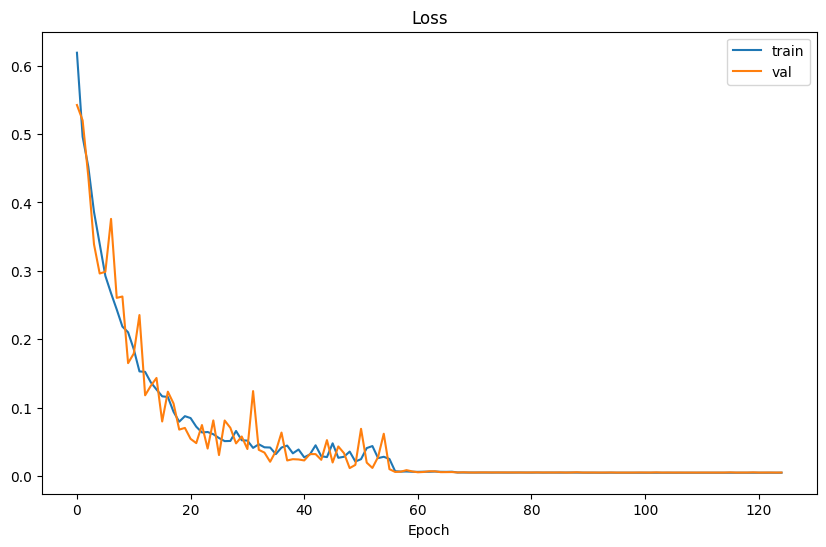

In [27]:
plt.figure(figsize=(10,6))
plt.title('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history[25:], '-', label='train')
plt.plot(val_loss_history[25:], '-', label='val')
plt.legend()
plt.show()


## 6、Different Hidden Layer Numbers
Change the hidden layer number and compare the performance of models of different layer numbers. <br>
I set 5 models of 2, 4, 8, 16 and 32 hidden layers respectively and each layer has the same neuron number.<br>
PS: All models use nn.ReLU() as the activation function and use the same loss function, optimizer, lr_scheduler etc.<br>
First, create and train the 5 models.

In [28]:
cfg_2 = [16 for _ in range(2)]
cfg_4 = [16 for _ in range(4)]
cfg_8 = [16 for _ in range(8)]
cfg_16 = [16 for _ in range(16)]
cfg_32 = [16 for _ in range(32)]

model_2 = fcn(cfg_2, nn.ReLU())
model_4 = fcn(cfg_4, nn.ReLU())
model_8 = fcn(cfg_8, nn.ReLU())
model_16 = fcn(cfg_16, nn.ReLU())
model_32 = fcn(cfg_32, nn.ReLU())

# criterion = nn.SmoothL1Loss()  # loss function
train_loss_history_list, val_loss_history_list = list(), list()
model_list = [model_2, model_4, model_8, model_16, model_32]
for model in model_list:
    criterion = nn.SmoothL1Loss()  # loss function
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, verbose=True)
    train_loss_history, val_loss_history = train(model, criterion, optimizer, lr_scheduler, loader_train, loader_val, epochs=10, verbose=True)
    train_loss_history_list.append(train_loss_history)
    val_loss_history_list.append(val_loss_history)
    print()


(Epoch 1 / 10) train_loss = 49.1240, val_loss = 21.8794
(Epoch 2 / 10) train_loss = 17.3800, val_loss = 15.8803
(Epoch 3 / 10) train_loss = 14.7060, val_loss = 14.4296
(Epoch 4 / 10) train_loss = 12.9109, val_loss = 12.4113
(Epoch 5 / 10) train_loss = 11.0605, val_loss = 10.3721
(Epoch 6 / 10) train_loss = 9.3323, val_loss = 8.7324
(Epoch 7 / 10) train_loss = 7.9753, val_loss = 7.6109
(Epoch 8 / 10) train_loss = 7.1126, val_loss = 6.9122
(Epoch 9 / 10) train_loss = 6.5993, val_loss = 6.4045
(Epoch 10 / 10) train_loss = 6.2771, val_loss = 6.1196

training time: Time 0:0:8

(Epoch 1 / 10) train_loss = 37.9767, val_loss = 17.6834
(Epoch 2 / 10) train_loss = 15.0636, val_loss = 14.2327
(Epoch 3 / 10) train_loss = 11.3296, val_loss = 9.7315
(Epoch 4 / 10) train_loss = 7.4415, val_loss = 6.0105
(Epoch 5 / 10) train_loss = 4.4459, val_loss = 3.5635
(Epoch 6 / 10) train_loss = 3.0139, val_loss = 2.6681
(Epoch 7 / 10) train_loss = 2.2553, val_loss = 2.0359
(Epoch 8 / 10) train_loss = 1.7104, va

Plot the validation loss of each model together to compare the results.

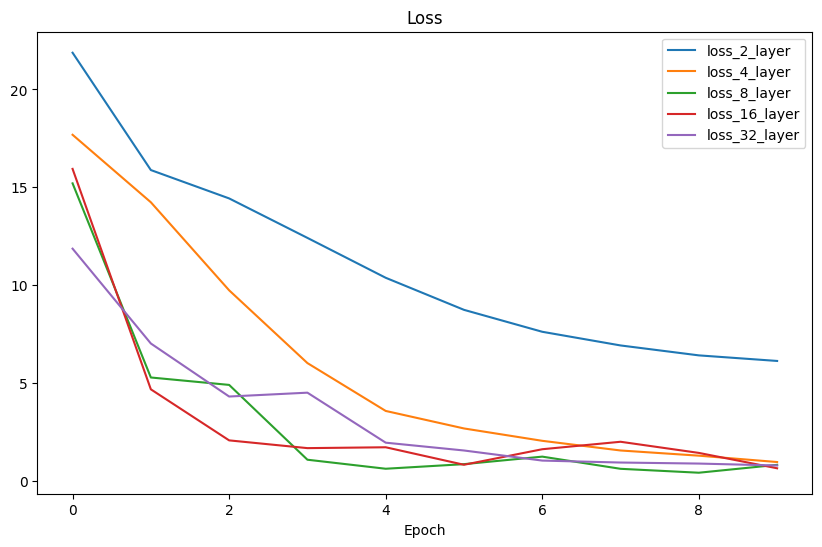

In [29]:
plt.figure(figsize=(10,6))
plt.title('Loss')
plt.xlabel('Epoch')
hidden_layers = [2, 4, 8, 16, 32]
for idx, l in enumerate(hidden_layers):
    plt.plot(val_loss_history_list[idx], '-', label=f'loss_{l}_layer')
plt.legend()
plt.show()

## 7、Different Neuron Numbers
Change the neuron number and see how performance will change.<br>
I set 4 models of 1 hidden layer that respectively have 32, 64, 128, 256 neurons.<br>
PS: All models use nn.ReLU() as the activation function and use the same loss function, optimizer, lr_scheduler etc.<br>
First, create and train the 4 models.

In [31]:
model_8_neuron = fcn([8], nn.ReLU())
model_16_neuron = fcn([16], nn.ReLU())
model_32_neuron = fcn([32], nn.ReLU())
model_64_neuron = fcn([64], nn.ReLU())

neuron_number = [8, 16, 32, 64]
train_loss_history_list, val_loss_history_list = list(), list()
model_list = [model_8_neuron, model_16_neuron, model_32_neuron, model_64_neuron]
for idx, model in enumerate(model_list):
    print("model_%d_neuron" % neuron_number[idx])
    criterion = nn.SmoothL1Loss()  # loss function
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, verbose=True)
    train_loss_history, val_loss_history = train(model, criterion, optimizer, lr_scheduler, loader_train, loader_val, epochs=10, verbose=True)
    train_loss_history_list.append(train_loss_history)
    val_loss_history_list.append(val_loss_history)

model_8_neuron
(Epoch 1 / 10) train_loss = 63.1824, val_loss = 59.2266
(Epoch 2 / 10) train_loss = 54.0805, val_loss = 49.4675
(Epoch 3 / 10) train_loss = 41.6090, val_loss = 36.7962
(Epoch 4 / 10) train_loss = 31.4007, val_loss = 28.3956
(Epoch 5 / 10) train_loss = 24.8243, val_loss = 22.9561
(Epoch 6 / 10) train_loss = 20.1209, val_loss = 18.7821
(Epoch 7 / 10) train_loss = 17.4577, val_loss = 17.1257
(Epoch 8 / 10) train_loss = 16.3092, val_loss = 16.3191
(Epoch 9 / 10) train_loss = 15.7122, val_loss = 15.6407
(Epoch 10 / 10) train_loss = 15.2895, val_loss = 15.3233

training time: Time 0:0:11
model_16_neuron
(Epoch 1 / 10) train_loss = 62.5140, val_loss = 56.7996
(Epoch 2 / 10) train_loss = 47.3316, val_loss = 38.7207
(Epoch 3 / 10) train_loss = 30.0471, val_loss = 25.2146
(Epoch 4 / 10) train_loss = 21.4486, val_loss = 19.0509
(Epoch 5 / 10) train_loss = 17.8168, val_loss = 17.1966
(Epoch 6 / 10) train_loss = 16.5343, val_loss = 16.3985
(Epoch 7 / 10) train_loss = 15.7450, val_los

Plot the validation loss of each model together to compare the results.

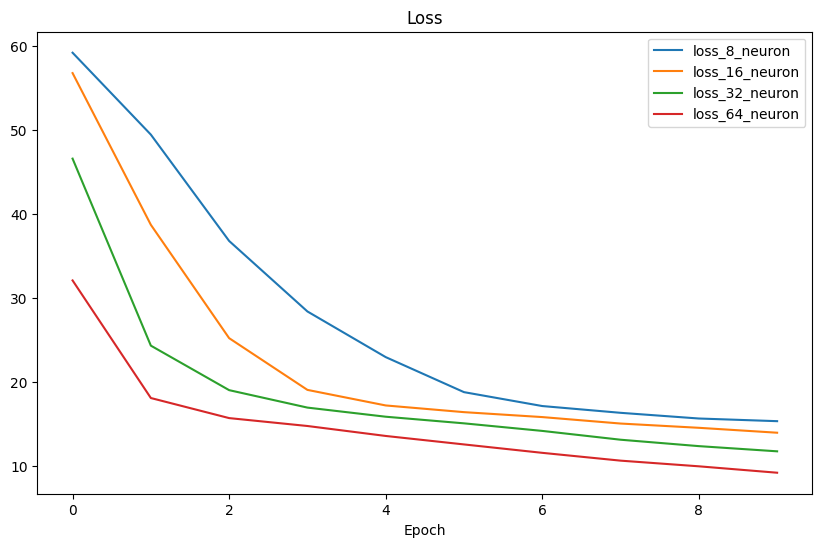

In [32]:
plt.figure(figsize=(10,6))
plt.title('Loss')
plt.xlabel('Epoch')
for idx, n in enumerate(neuron_number):
    plt.plot(val_loss_history_list[idx], '-', label=f'loss_{n}_neuron')
plt.legend()
plt.show()

## 6、Different Activation Functions
Try different activation functions and see how performance will change. <br>
I set 4 models using Sigmoid, Tanh, ReLu, LeakyReLU respectively.<br>
PS: All models has 1 hidden layer with 32 neurons and use the same loss function, optimizer, lr_scheduler etc.<br>
First, create and train the 4 models.

In [33]:
model_sigmoid = fcn([32], nn.Sigmoid())
model_tanh = fcn([32], nn.Tanh())
model_relu = fcn([32], nn.ReLU())
model_leakyrelu = fcn([32], nn.LeakyReLU())
model_list = [model_sigmoid, model_tanh, model_relu, model_leakyrelu]

activation = ['Sigmoid', 'Tanh', 'ReLU', 'LeakyReLU']
train_loss_history_list, val_loss_history_list = list(), list()

for idx, model in enumerate(model_list):
    print("model_" + activation[idx])
    criterion = nn.SmoothL1Loss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, verbose=True)
    train_loss_history, val_loss_history = train(model, criterion, optimizer, lr_scheduler, loader_train, loader_val, epochs=10, verbose=True)
    train_loss_history_list.append(train_loss_history)
    val_loss_history_list.append(val_loss_history)

model_Sigmoid
(Epoch 1 / 10) train_loss = 64.0623, val_loss = 62.0174
(Epoch 2 / 10) train_loss = 58.8991, val_loss = 56.2649
(Epoch 3 / 10) train_loss = 53.3914, val_loss = 51.9687
(Epoch 4 / 10) train_loss = 48.0764, val_loss = 46.5122
(Epoch 5 / 10) train_loss = 44.1254, val_loss = 42.4011
(Epoch 6 / 10) train_loss = 41.3930, val_loss = 40.7496
(Epoch 7 / 10) train_loss = 39.7740, val_loss = 39.3387
(Epoch 8 / 10) train_loss = 38.8878, val_loss = 38.5345
(Epoch 9 / 10) train_loss = 38.3777, val_loss = 38.7864
(Epoch 10 / 10) train_loss = 38.1084, val_loss = 38.1218

training time: Time 0:0:10
model_Tanh
(Epoch 1 / 10) train_loss = 65.5819, val_loss = 66.6457
(Epoch 2 / 10) train_loss = 61.7475, val_loss = 59.8688
(Epoch 3 / 10) train_loss = 55.6104, val_loss = 52.4322
(Epoch 4 / 10) train_loss = 49.7713, val_loss = 47.2304
(Epoch 5 / 10) train_loss = 45.6499, val_loss = 44.0703
(Epoch 6 / 10) train_loss = 42.6465, val_loss = 41.0537
(Epoch 7 / 10) train_loss = 40.5763, val_loss = 40

Plot the validation loss of each model together to compare the results.

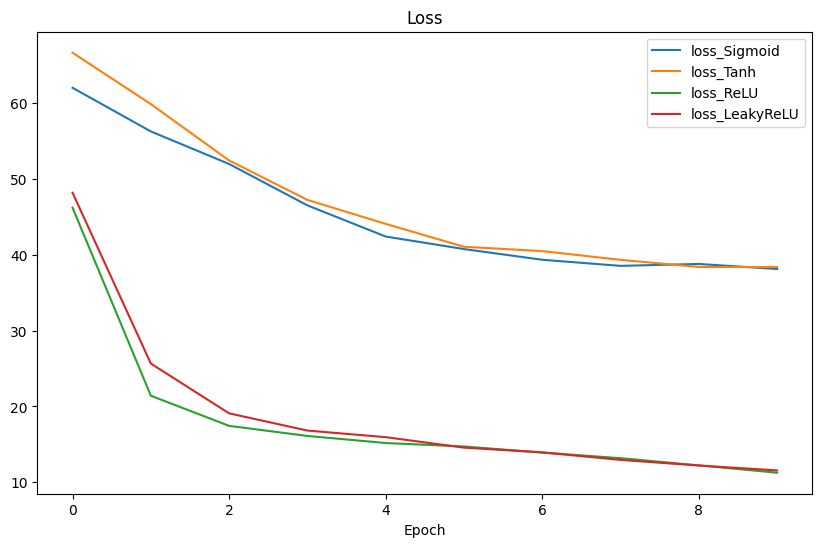

In [34]:
plt.figure(figsize=(10,6))
plt.title('Loss')
plt.xlabel('Epoch')
for idx, act in enumerate(activation):
    plt.plot(val_loss_history_list[idx], '-', label='loss_'+ act)
plt.legend()
plt.show()